<img align="left" src="https://lever-client-logos.s3.amazonaws.com/864372b1-534c-480e-acd5-9711f850815c-1524247202159.png" width=200>
<br></br>
<br></br>

# Topic Modeling
## *Data Science Unit 4 Sprint 1 Assignment 4*

Analyze a corpus of Amazon reviews from Unit 4 Sprint 1 Module 1's lecture using topic modeling: 

- Fit a Gensim LDA topic model on Amazon Reviews
- Select appropriate number of topics
- Create some dope visualization of the topics
- Write a few bullets on your findings in markdown at the end
- **Note**: You don't *have* to use generators for this assignment

In [1]:
import numpy as np
import gensim
from collections import Counter
import re
import sys

# Plotting
import squarify
import matplotlib.pyplot as plt
import seaborn as sns

# NLP Libraries
import spacy
from spacy.tokenizer import Tokenizer
from nltk.stem import PorterStemmer

from gensim.utils import simple_preprocess
from gensim.parsing.preprocessing import STOPWORDS
from gensim import corpora

from gensim.models.ldamulticore import LdaMulticore
from gensim.models.coherencemodel import CoherenceModel

import pandas as pd

In [2]:
df = pd.read_csv('./data/Datafiniti_Amazon_Consumer_Reviews_of_Amazon_Products_May19.csv')

In [3]:
def clean_text(text):
    text = text.replace('\n', ' ')                # remove newline
    text = text.replace('/', ' ')                 # remove forward slashes
    text = re.sub(r'[^a-zA-Z ^0-9]', '', text)    # letters and numbers only
    text = text.lower()                           # lower case
    text = re.sub(r'(x.[0-9])', '', text)         # remove special characters
    return text

df['reviews.text'] = df.apply(lambda x: clean_text(x['reviews.text']), axis=1)

In [4]:
nlp = spacy.load("en_core_web_lg")
tokenizer = Tokenizer(nlp.vocab)
STOP_WORDS = nlp.Defaults.stop_words.union(['batteries', 'I', 'amazon', 'i', 'Amazon', 'it', "it's", 'it.', 'the', 'this'])

def tokenize(text):
    return [token for token in simple_preprocess(text) if token not in STOPWORDS]

In [5]:
num_reviews = df.shape[0]
texts = []

for i in range (0, num_reviews):
    texts.append(tokenize(df['reviews.text'][i]))

In [6]:
texts[0]

['order',
 'item',
 'bad',
 'quality',
 'missing',
 'backup',
 'spring',
 'pcs',
 'aluminum',
 'battery',
 'work']

In [7]:
# A Dictionary Representation of all the words in our corpus
id2word = corpora.Dictionary(texts)

In [8]:
# Id of the word in the dictionary
id2word.token2id['battery']

3

In [9]:
# Length of vocabulary across all documents
len(id2word.keys())

11665

In [10]:
# Let's remove extreme values from the dataset
id2word.filter_extremes(no_below=5, no_above=0.95)

In [11]:
# Length of vocabulary across all documents
len(id2word.keys())

3603

In [12]:
# Creating bag of words
corpus = [id2word.doc2bow(text) for text in texts]
len(corpus)

28332

In [13]:
corpus[0][:10]

[(0, 1),
 (1, 1),
 (2, 1),
 (3, 1),
 (4, 1),
 (5, 1),
 (6, 1),
 (7, 1),
 (8, 1),
 (9, 1)]

In [14]:
# LDA model
lda = LdaMulticore(corpus=corpus,    # data
                   id2word=id2word,  # dictionary
                   random_state=723812, # different results 
                   num_topics = 15, 
                   passes=10,        # default is 100
                   workers=8
                  )

In [15]:
# Strip out the words
words = [re.findall(r'"([^"]*)"',t[1]) for t in lda.print_topics()]

In [16]:
topics = [' '.join(t[0:5]) for t in words]

In [17]:
for id, t in enumerate(topics): 
    print(f"------ Topic {id} ------")
    print(t, end="\n\n")

------ Topic 0 ------
great tablet apps old play

------ Topic 1 ------
batteries battery long use life

------ Topic 2 ------
good price great quality tablet

------ Topic 3 ------
loves tablet old bought year

------ Topic 4 ------
kindle read love reading light

------ Topic 5 ------
like kindle screen think use

------ Topic 6 ------
tablet use amazon apps good

------ Topic 7 ------
easy use tablet great love

------ Topic 8 ------
great product works work tablet

------ Topic 9 ------
batteries price great good long

------ Topic 10 ------
amazon good tablet like far

------ Topic 11 ------
tablet great kids apps use

------ Topic 12 ------
great tablet games reading gift

------ Topic 13 ------
love kindle tablet new bought

------ Topic 14 ------
batteries great buy deal work



In [18]:
def compute_coherence_values(dictionary, corpus, limit, start=2, step=3, passes=5):
    """
    Compute c_v coherence for various number of topics

    Parameters:
    ----------
    dictionary : Gensim dictionary
    corpus : Gensim corpus
    path : path to input texts
    limit : Max num of topics
    passes: the number of times the entire lda model & coherence values are calculated

    Returns:
    -------
    coherence_values : Coherence values corresponding to the LDA model with respective number of topics
    """
    
    coherence_values = []
    
    for iter_ in range(passes):
        for num_topics in range(start, limit, step):
            model = LdaMulticore(corpus=corpus, num_topics=num_topics, id2word=dictionary, workers=4)
            coherencemodel = CoherenceModel(model=model,dictionary=dictionary,corpus=corpus, coherence='u_mass')
            coherence_values.append({'pass': iter_, 
                                     'num_topics': num_topics, 
                                     'coherence_score': coherencemodel.get_coherence()
                                    })

    return coherence_values

In [19]:
# Can take a long time to run.
coherence_values = compute_coherence_values(dictionary=id2word, 
                                            corpus=corpus, 
                                            limit=20)

In [20]:
topic_coherence = pd.DataFrame.from_records(coherence_values)

In [21]:
topic_coherence.head()

,coherence_score,num_topics,pass
0,-2.599892,2,0
1,-2.561652,5,0
2,-2.585511,8,0
3,-2.685527,11,0
4,-2.664808,14,0


/Users/JKMacBook/opt/anaconda3/envs/nlp-1/lib/python3.7/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


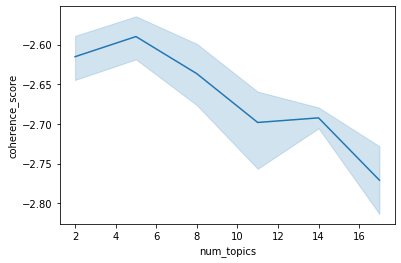

In [22]:
ax = sns.lineplot(x="num_topics", y="coherence_score", data=topic_coherence)

In [23]:
lda[corpus[0]]

[(0, 0.09564636), (1, 0.15062313), (2, 0.17506519), (5, 0.51199853)]

In [24]:
distro = [lda[d] for d in corpus]

In [25]:
distro[0]

[(0, 0.0996472), (1, 0.13288759), (2, 0.1797776), (5, 0.5210208)]

In [26]:
# Fills in list with the empty values
distro = [lda[d] for d in corpus]

def update(doc):
        d_dist = {k:0 for k in range(0,15)}
        for t in doc:
            d_dist[t[0]] = t[1]
        return d_dist
    
new_distro = [update(d) for d in distro]

In [31]:
new_df = pd.DataFrame.from_records(new_distro, index=df['name'])
new_df.columns = topics
new_df.groupby('name').mean()

,great tablet apps old play,batteries battery long use life,good price great quality tablet,loves tablet old bought year,kindle read love reading light,like kindle screen think use,tablet use amazon apps good,easy use tablet great love,great product works work tablet,batteries price great good long,amazon good tablet like far,tablet great kids apps use,great tablet games reading gift,love kindle tablet new bought,batteries great buy deal work
name,,,,,,,,,,,,,,,
"All-New Fire 7 Tablet with Alexa, 7"" Display, 8 GB - Marine Blue",0.014359,0.020453,0.093423,0.219853,0.038248,0.016460,0.065211,0.094391,0.107152,0.011783,0.032150,0.072238,0.103463,0.042169,0.008403
"All-New Fire HD 8 Kids Edition Tablet, 8 HD Display, 32 GB, Blue Kid-Proof Case",0.090385,0.011069,0.040111,0.332675,0.018585,0.011956,0.070494,0.049508,0.083093,0.013447,0.036250,0.074091,0.069439,0.024650,0.015087
"All-New Fire HD 8 Kids Edition Tablet, 8 HD Display, 32 GB, Pink Kid-Proof Case",0.064030,0.012903,0.031817,0.403269,0.019755,0.018346,0.034076,0.056390,0.077178,0.009739,0.035687,0.063094,0.067792,0.026310,0.015609
"All-New Fire HD 8 Tablet with Alexa, 8 HD Display, 16 GB, Marine Blue - with Special Offers",0.035582,0.013847,0.083466,0.148778,0.052428,0.024517,0.110984,0.115694,0.070676,0.026499,0.016497,0.086724,0.082162,0.048331,0.016276
"All-New Fire HD 8 Tablet with Alexa, 8 HD Display, 32 GB, Marine Blue - with Special Offers",0.068596,0.025638,0.063507,0.119661,0.055042,0.028571,0.099658,0.119010,0.051568,0.017807,0.040945,0.068279,0.087253,0.064918,0.029720
"All-New Fire HD 8 Tablet, 8 HD Display, Wi-Fi, 16 GB - Includes Special Offers, Black",0.044117,0.014094,0.086995,0.124155,0.058452,0.023757,0.088162,0.137117,0.069798,0.018915,0.024211,0.084074,0.089552,0.059447,0.013984
"All-New Fire HD 8 Tablet, 8 HD Display, Wi-Fi, 16 GB - Includes Special Offers, Blue",0.077031,0.013492,0.079755,0.093555,0.071727,0.025060,0.081143,0.171294,0.083074,0.026461,0.016851,0.052801,0.096206,0.035723,0.003144
"All-New Fire HD 8 Tablet, 8 HD Display, Wi-Fi, 32 GB - Includes Special Offers, Black",0.042446,0.010881,0.070378,0.109597,0.088651,0.035211,0.078432,0.127643,0.070308,0.006860,0.021451,0.082025,0.079011,0.091737,0.023294
"All-New Fire HD 8 Tablet, 8 HD Display, Wi-Fi, 32 GB - Includes Special Offers, Blue",0.047115,0.011155,0.065999,0.119649,0.097513,0.031161,0.078698,0.111995,0.070935,0.006671,0.023760,0.073215,0.082047,0.098069,0.020869


## Stretch Goals

* Incorporate Named Entity Recognition in your analysis
* Incorporate some custom pre-processing from our previous lessons (like spacy lemmatization)
* Analyze a dataset of interest to you with topic modeling